# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [35]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

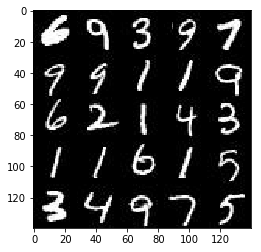

In [36]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

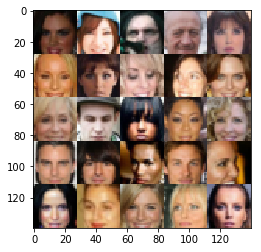

In [37]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [38]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.2.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [39]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_inputs = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels))
    z_data = tf.placeholder(tf.float32, (None, z_dim))
    lr = tf.placeholder(tf.float32)

    return real_inputs, z_data, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/home/shinto/anaconda3/envs/py3xgb/lib/python3.6/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/home/shinto/anaconda3/envs/py3xgb/lib/python3.6/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/home/shinto/anaconda3/envs/py3xgb/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/home/shinto/anaconda3/envs/py3xgb/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/home/shinto/anaconda3/envs/py3xgb/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 477, in start\n    ioloop.IOLoop.instance().start()', 'File "/hom

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [40]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        some_factor = 0.2
        h1 = tf.layers.conv2d(images, filters=64, kernel_size=5, strides=2, padding='same')
        h1 = tf.nn.relu(h1)
        
        h2 = tf.layers.conv2d(h1, filters=128, kernel_size=5, strides=2, padding='same')
        h2 = tf.layers.batch_normalization(h2, training=True)
        h2 = tf.maximum( 0.2 * h2, h2)
        
        h3 = tf.layers.conv2d(h1, filters=256, kernel_size=5, strides=2, padding='same')
        h3 = tf.layers.batch_normalization(h3, training=True)
        h3 = tf.maximum( 0.2 * h3, h3)
        
        h4 = tf.reshape(h3, [-1, 4*4*256])
        logits = tf.layers.dense(h4, 1, activation=None)
        output = tf.sigmoid(logits)

    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [41]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse = not is_train) as g_scope:
        alpha = 0.2
        
        h1 = tf.layers.dense(z, units=2*2*512)
        h1 = tf.reshape(h1, (-1, 2, 2, 512))
        h1 = tf.layers.batch_normalization(h1, training=is_train)
        h1 = tf.maximum(alpha * h1, h1)
        
        h2 = tf.layers.conv2d_transpose(h1, filters=256, kernel_size=5, strides=2, padding='valid')
        h2 = tf.layers.batch_normalization(h2, training=is_train)
        h2 = tf.maximum(alpha * h2, h2)
        
        h3 = tf.layers.conv2d_transpose(h2, filters=128, kernel_size=5, strides=2, padding='same')
        h3 = tf.layers.batch_normalization(h3, training=is_train)
        h3 = tf.maximum(alpha * h3, h3)
        
        logits = tf.layers.conv2d_transpose(h3, filters=out_channel_dim, kernel_size=5, strides=2, padding='same')
        out = tf.tanh(logits)
        
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [42]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    gen_model = generator(input_z, out_channel_dim)
    disc_model_real, disc_logits_real = discriminator(input_real)
    disc_model_fake, disc_logits_fake = discriminator(gen_model, reuse=True)
    
    disc_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=disc_logits_real,
                                                                           labels=tf.ones_like(disc_model_real)*(1-0.1)))
    disc_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=disc_logits_fake,
                                                                           labels=tf.zeros_like(disc_model_fake)))
    gen_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=disc_logits_fake,
                                                                     labels=tf.ones_like(disc_model_fake)))
    
    disc_loss = disc_loss_real + disc_loss_fake
    
    return disc_loss, gen_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [43]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    train_vars = tf.trainable_variables()
    gen_vars = [x for x in train_vars if x.name.startswith('generator')]
    disc_vars = [x for x in train_vars if x.name.startswith('discriminator')]
    
    disc_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=disc_vars)
    gen_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=gen_vars)
    
    return disc_train_opt, gen_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [44]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [45]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    _, width, height, channels = data_shape
    input_real, input_z, lr = model_inputs(width, height, channels, z_dim)
    disc_loss, gen_loss = model_loss(input_real, input_z, channels)
    disc_opt, gen_opt = model_opt(disc_loss, gen_loss, lr, beta1)
    print(data_shape)
    
    i = 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                batch_images = batch_images * 2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                sess.run(disc_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                sess.run(gen_opt, feed_dict={input_z: batch_z, lr: learning_rate})
                i += 1
                if i % 10 == 0:
                    train_loss_disc = disc_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_gen = gen_loss.eval({input_z: batch_z})
                    print('Epoch %d/%d Discriminator loss %.4f Generator loss %.4f' % (epoch_i, epoch_count,
                                                                                       train_loss_disc, train_loss_gen ))
                if i % 100 == 0:
                    show_generator_output(sess, 50, input_z, channels, data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

(60000, 28, 28, 1)
Epoch 0/2 Discriminator loss 1.2089 Generator loss 0.7544
Epoch 0/2 Discriminator loss 1.4727 Generator loss 0.8702
Epoch 0/2 Discriminator loss 1.0984 Generator loss 0.9975
Epoch 0/2 Discriminator loss 1.1792 Generator loss 0.8979
Epoch 0/2 Discriminator loss 1.1932 Generator loss 0.9894
Epoch 0/2 Discriminator loss 1.0632 Generator loss 1.0415
Epoch 0/2 Discriminator loss 1.0875 Generator loss 1.0411
Epoch 0/2 Discriminator loss 1.0812 Generator loss 1.0427
Epoch 0/2 Discriminator loss 1.1235 Generator loss 1.0454
Epoch 0/2 Discriminator loss 1.1153 Generator loss 1.0412


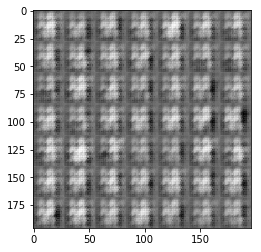

Epoch 0/2 Discriminator loss 0.9204 Generator loss 1.2230
Epoch 0/2 Discriminator loss 1.2160 Generator loss 1.1807
Epoch 0/2 Discriminator loss 1.2993 Generator loss 0.9567
Epoch 0/2 Discriminator loss 1.1315 Generator loss 1.1961
Epoch 0/2 Discriminator loss 1.0041 Generator loss 1.1229
Epoch 0/2 Discriminator loss 1.0576 Generator loss 1.1262
Epoch 0/2 Discriminator loss 1.0689 Generator loss 1.1554
Epoch 0/2 Discriminator loss 1.0392 Generator loss 1.1064
Epoch 0/2 Discriminator loss 1.2140 Generator loss 1.0008
Epoch 0/2 Discriminator loss 1.0442 Generator loss 1.1817


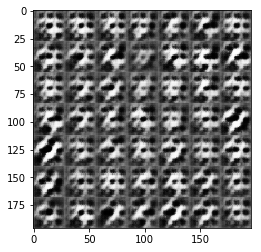

Epoch 0/2 Discriminator loss 1.0303 Generator loss 1.1534
Epoch 0/2 Discriminator loss 1.1655 Generator loss 0.9932
Epoch 0/2 Discriminator loss 1.0652 Generator loss 1.0792
Epoch 0/2 Discriminator loss 1.0831 Generator loss 1.1717
Epoch 0/2 Discriminator loss 1.5068 Generator loss 1.1024
Epoch 0/2 Discriminator loss 1.1586 Generator loss 1.6576
Epoch 0/2 Discriminator loss 0.9461 Generator loss 1.2291
Epoch 0/2 Discriminator loss 1.1583 Generator loss 1.0769
Epoch 0/2 Discriminator loss 1.1264 Generator loss 1.1908
Epoch 0/2 Discriminator loss 0.9846 Generator loss 1.4538


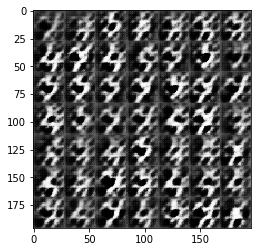

Epoch 0/2 Discriminator loss 1.0898 Generator loss 1.0177
Epoch 0/2 Discriminator loss 1.0423 Generator loss 1.1005
Epoch 0/2 Discriminator loss 1.0607 Generator loss 1.2631
Epoch 0/2 Discriminator loss 1.1747 Generator loss 1.1050
Epoch 0/2 Discriminator loss 1.2174 Generator loss 1.2803
Epoch 0/2 Discriminator loss 1.2877 Generator loss 0.7054
Epoch 0/2 Discriminator loss 0.9528 Generator loss 1.2222
Epoch 0/2 Discriminator loss 1.0407 Generator loss 1.1360
Epoch 0/2 Discriminator loss 1.0251 Generator loss 1.0856
Epoch 0/2 Discriminator loss 1.0262 Generator loss 1.2486


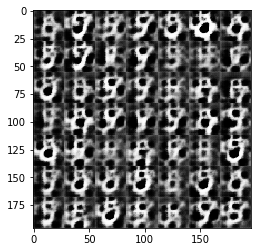

Epoch 0/2 Discriminator loss 0.9971 Generator loss 1.2250
Epoch 0/2 Discriminator loss 1.3126 Generator loss 1.0044
Epoch 0/2 Discriminator loss 1.2547 Generator loss 1.3574
Epoch 0/2 Discriminator loss 0.9551 Generator loss 1.2439
Epoch 0/2 Discriminator loss 1.0216 Generator loss 1.2147
Epoch 0/2 Discriminator loss 1.0300 Generator loss 1.2152
Epoch 0/2 Discriminator loss 1.0740 Generator loss 1.3554
Epoch 0/2 Discriminator loss 0.9954 Generator loss 1.1895
Epoch 0/2 Discriminator loss 1.0986 Generator loss 1.1371
Epoch 0/2 Discriminator loss 1.1581 Generator loss 0.9851


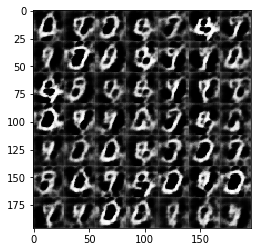

Epoch 0/2 Discriminator loss 1.1483 Generator loss 1.0423
Epoch 0/2 Discriminator loss 1.1777 Generator loss 0.8940
Epoch 0/2 Discriminator loss 1.0798 Generator loss 1.0097
Epoch 0/2 Discriminator loss 1.1195 Generator loss 1.0436
Epoch 0/2 Discriminator loss 1.1374 Generator loss 1.0259
Epoch 0/2 Discriminator loss 1.2162 Generator loss 1.0442
Epoch 0/2 Discriminator loss 1.0457 Generator loss 1.2042
Epoch 0/2 Discriminator loss 1.1524 Generator loss 1.0222
Epoch 0/2 Discriminator loss 1.1605 Generator loss 1.0914
Epoch 0/2 Discriminator loss 1.1647 Generator loss 1.0524


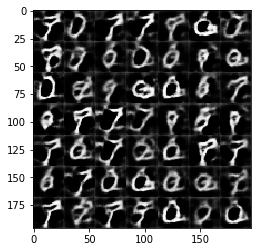

Epoch 0/2 Discriminator loss 1.0083 Generator loss 1.2096
Epoch 0/2 Discriminator loss 1.0921 Generator loss 1.1471
Epoch 0/2 Discriminator loss 1.1531 Generator loss 0.9509
Epoch 0/2 Discriminator loss 1.0464 Generator loss 1.1319
Epoch 0/2 Discriminator loss 1.1527 Generator loss 1.0002
Epoch 0/2 Discriminator loss 1.0994 Generator loss 1.0631
Epoch 0/2 Discriminator loss 1.1317 Generator loss 1.1052
Epoch 0/2 Discriminator loss 1.1123 Generator loss 1.2252
Epoch 0/2 Discriminator loss 1.0834 Generator loss 1.0378
Epoch 0/2 Discriminator loss 1.1744 Generator loss 1.0619


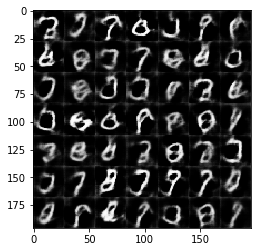

Epoch 0/2 Discriminator loss 1.1301 Generator loss 1.0302
Epoch 0/2 Discriminator loss 1.1751 Generator loss 1.0484
Epoch 0/2 Discriminator loss 1.0486 Generator loss 1.0902
Epoch 0/2 Discriminator loss 1.1557 Generator loss 1.0778
Epoch 0/2 Discriminator loss 1.1655 Generator loss 0.8492
Epoch 0/2 Discriminator loss 1.0612 Generator loss 1.0595
Epoch 0/2 Discriminator loss 1.1324 Generator loss 1.0392
Epoch 0/2 Discriminator loss 1.0625 Generator loss 1.0697
Epoch 0/2 Discriminator loss 1.1733 Generator loss 1.1717
Epoch 0/2 Discriminator loss 1.0975 Generator loss 1.1862


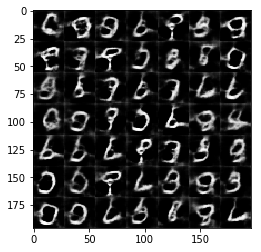

Epoch 0/2 Discriminator loss 1.1010 Generator loss 0.9993
Epoch 0/2 Discriminator loss 1.1346 Generator loss 1.4700
Epoch 0/2 Discriminator loss 1.1295 Generator loss 1.0543
Epoch 0/2 Discriminator loss 1.1266 Generator loss 1.0241
Epoch 0/2 Discriminator loss 1.1516 Generator loss 0.9094
Epoch 0/2 Discriminator loss 1.1868 Generator loss 1.0688
Epoch 0/2 Discriminator loss 1.1941 Generator loss 0.9372
Epoch 0/2 Discriminator loss 1.0590 Generator loss 0.9814
Epoch 0/2 Discriminator loss 1.1217 Generator loss 1.1794
Epoch 0/2 Discriminator loss 1.1134 Generator loss 1.1523


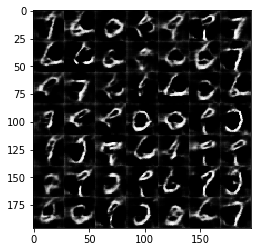

Epoch 0/2 Discriminator loss 1.2253 Generator loss 1.1435
Epoch 0/2 Discriminator loss 1.1757 Generator loss 1.1772
Epoch 0/2 Discriminator loss 1.2743 Generator loss 0.9126
Epoch 1/2 Discriminator loss 1.1898 Generator loss 0.9512
Epoch 1/2 Discriminator loss 1.1614 Generator loss 1.2315
Epoch 1/2 Discriminator loss 1.0444 Generator loss 1.0767
Epoch 1/2 Discriminator loss 1.0815 Generator loss 1.0001
Epoch 1/2 Discriminator loss 1.0640 Generator loss 1.0490
Epoch 1/2 Discriminator loss 1.1326 Generator loss 1.2309
Epoch 1/2 Discriminator loss 1.2336 Generator loss 1.2815


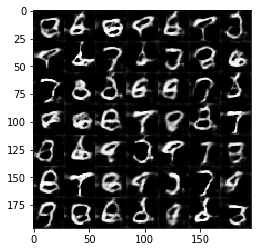

Epoch 1/2 Discriminator loss 1.0392 Generator loss 1.1535
Epoch 1/2 Discriminator loss 1.1153 Generator loss 0.9752
Epoch 1/2 Discriminator loss 1.1347 Generator loss 1.2784
Epoch 1/2 Discriminator loss 1.0763 Generator loss 1.2598
Epoch 1/2 Discriminator loss 1.1010 Generator loss 0.9721
Epoch 1/2 Discriminator loss 1.1204 Generator loss 0.8202
Epoch 1/2 Discriminator loss 1.2386 Generator loss 1.1486
Epoch 1/2 Discriminator loss 1.0877 Generator loss 1.0789
Epoch 1/2 Discriminator loss 1.1091 Generator loss 1.2607
Epoch 1/2 Discriminator loss 1.1656 Generator loss 1.2708


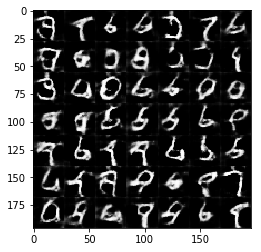

Epoch 1/2 Discriminator loss 1.0436 Generator loss 0.9643
Epoch 1/2 Discriminator loss 1.1085 Generator loss 0.9706
Epoch 1/2 Discriminator loss 1.2475 Generator loss 1.8288
Epoch 1/2 Discriminator loss 1.2107 Generator loss 0.9381
Epoch 1/2 Discriminator loss 1.1492 Generator loss 1.0435
Epoch 1/2 Discriminator loss 1.6945 Generator loss 1.6697
Epoch 1/2 Discriminator loss 1.2031 Generator loss 1.1544
Epoch 1/2 Discriminator loss 1.1752 Generator loss 0.8977
Epoch 1/2 Discriminator loss 1.2579 Generator loss 1.0191
Epoch 1/2 Discriminator loss 1.1103 Generator loss 1.0730


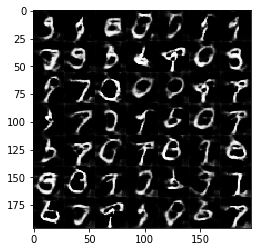

Epoch 1/2 Discriminator loss 1.0765 Generator loss 1.1592
Epoch 1/2 Discriminator loss 1.1111 Generator loss 1.0863
Epoch 1/2 Discriminator loss 1.1347 Generator loss 1.2111
Epoch 1/2 Discriminator loss 1.1015 Generator loss 1.0160
Epoch 1/2 Discriminator loss 1.1372 Generator loss 1.0184
Epoch 1/2 Discriminator loss 1.2200 Generator loss 1.0814
Epoch 1/2 Discriminator loss 1.1170 Generator loss 1.2214
Epoch 1/2 Discriminator loss 1.1395 Generator loss 1.0220
Epoch 1/2 Discriminator loss 1.1091 Generator loss 1.0809
Epoch 1/2 Discriminator loss 1.1603 Generator loss 1.1633


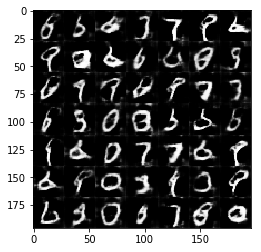

Epoch 1/2 Discriminator loss 1.0894 Generator loss 0.9561
Epoch 1/2 Discriminator loss 1.1888 Generator loss 1.0127
Epoch 1/2 Discriminator loss 1.0803 Generator loss 1.4123
Epoch 1/2 Discriminator loss 1.1465 Generator loss 1.0154
Epoch 1/2 Discriminator loss 1.2004 Generator loss 0.8636
Epoch 1/2 Discriminator loss 1.0815 Generator loss 1.2314
Epoch 1/2 Discriminator loss 1.1291 Generator loss 0.9896
Epoch 1/2 Discriminator loss 1.2936 Generator loss 0.6690
Epoch 1/2 Discriminator loss 1.1670 Generator loss 1.0912
Epoch 1/2 Discriminator loss 1.0654 Generator loss 1.1197


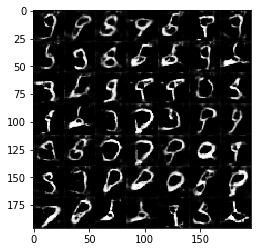

Epoch 1/2 Discriminator loss 1.2280 Generator loss 1.4386
Epoch 1/2 Discriminator loss 1.0859 Generator loss 0.9594
Epoch 1/2 Discriminator loss 1.1040 Generator loss 1.4440
Epoch 1/2 Discriminator loss 1.1628 Generator loss 0.9766
Epoch 1/2 Discriminator loss 1.1676 Generator loss 0.8060
Epoch 1/2 Discriminator loss 1.8053 Generator loss 1.4917
Epoch 1/2 Discriminator loss 1.2952 Generator loss 0.8372
Epoch 1/2 Discriminator loss 1.1531 Generator loss 0.9778
Epoch 1/2 Discriminator loss 1.1486 Generator loss 1.0180
Epoch 1/2 Discriminator loss 1.1414 Generator loss 0.9750


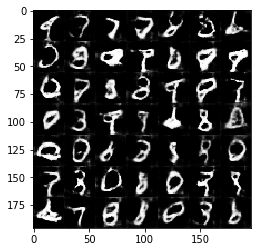

Epoch 1/2 Discriminator loss 1.0777 Generator loss 1.0268
Epoch 1/2 Discriminator loss 1.1039 Generator loss 0.9519
Epoch 1/2 Discriminator loss 1.1135 Generator loss 1.1494
Epoch 1/2 Discriminator loss 1.0952 Generator loss 1.0012
Epoch 1/2 Discriminator loss 1.1386 Generator loss 1.2020
Epoch 1/2 Discriminator loss 1.0524 Generator loss 1.0369
Epoch 1/2 Discriminator loss 1.1022 Generator loss 1.0137
Epoch 1/2 Discriminator loss 1.0859 Generator loss 1.1993
Epoch 1/2 Discriminator loss 1.1067 Generator loss 1.2159
Epoch 1/2 Discriminator loss 1.1636 Generator loss 1.2326


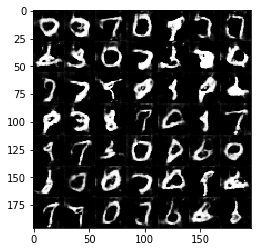

Epoch 1/2 Discriminator loss 1.1045 Generator loss 1.1606
Epoch 1/2 Discriminator loss 1.0364 Generator loss 1.0844
Epoch 1/2 Discriminator loss 1.1464 Generator loss 0.8598
Epoch 1/2 Discriminator loss 1.2444 Generator loss 1.1848
Epoch 1/2 Discriminator loss 1.0732 Generator loss 1.0352
Epoch 1/2 Discriminator loss 1.1502 Generator loss 0.9244
Epoch 1/2 Discriminator loss 1.0410 Generator loss 1.0695
Epoch 1/2 Discriminator loss 1.1074 Generator loss 0.9670
Epoch 1/2 Discriminator loss 1.0688 Generator loss 1.2135
Epoch 1/2 Discriminator loss 1.2352 Generator loss 1.2281


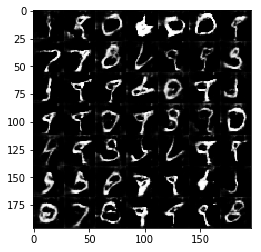

Epoch 1/2 Discriminator loss 1.1558 Generator loss 1.0149
Epoch 1/2 Discriminator loss 1.0637 Generator loss 1.0898
Epoch 1/2 Discriminator loss 1.1059 Generator loss 0.9449
Epoch 1/2 Discriminator loss 1.1056 Generator loss 1.0808
Epoch 1/2 Discriminator loss 1.0530 Generator loss 1.1402
Epoch 1/2 Discriminator loss 1.0148 Generator loss 1.1524
Epoch 1/2 Discriminator loss 1.0620 Generator loss 1.1086
Epoch 1/2 Discriminator loss 1.1100 Generator loss 0.8659
Epoch 1/2 Discriminator loss 1.1094 Generator loss 1.1450
Epoch 1/2 Discriminator loss 1.0736 Generator loss 1.2377


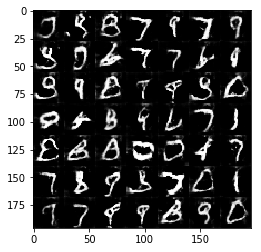

Epoch 1/2 Discriminator loss 1.2131 Generator loss 0.8098
Epoch 1/2 Discriminator loss 1.1079 Generator loss 1.4541
Epoch 1/2 Discriminator loss 1.0947 Generator loss 1.1128
Epoch 1/2 Discriminator loss 1.1649 Generator loss 0.9958
Epoch 1/2 Discriminator loss 1.0392 Generator loss 1.1866
Epoch 1/2 Discriminator loss 1.1520 Generator loss 0.8429
Epoch 1/2 Discriminator loss 1.0573 Generator loss 1.0842


In [46]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

(202599, 28, 28, 3)
Epoch 0/1 Discriminator loss 1.1947 Generator loss 0.8639
Epoch 0/1 Discriminator loss 1.3196 Generator loss 1.2537
Epoch 0/1 Discriminator loss 1.0295 Generator loss 1.1793
Epoch 0/1 Discriminator loss 0.9889 Generator loss 1.2938
Epoch 0/1 Discriminator loss 1.1455 Generator loss 1.0605
Epoch 0/1 Discriminator loss 0.9727 Generator loss 1.2659
Epoch 0/1 Discriminator loss 1.0391 Generator loss 1.0362
Epoch 0/1 Discriminator loss 0.8801 Generator loss 1.3420
Epoch 0/1 Discriminator loss 0.9874 Generator loss 1.4491
Epoch 0/1 Discriminator loss 0.9094 Generator loss 1.2085


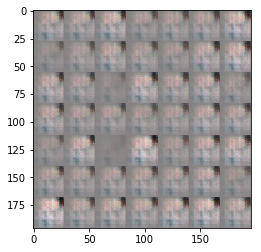

Epoch 0/1 Discriminator loss 0.9625 Generator loss 1.2068
Epoch 0/1 Discriminator loss 0.7007 Generator loss 2.0387
Epoch 0/1 Discriminator loss 0.9516 Generator loss 1.3650
Epoch 0/1 Discriminator loss 0.9065 Generator loss 1.3567
Epoch 0/1 Discriminator loss 0.9009 Generator loss 1.1925
Epoch 0/1 Discriminator loss 1.0017 Generator loss 1.5757
Epoch 0/1 Discriminator loss 1.1908 Generator loss 0.9031
Epoch 0/1 Discriminator loss 0.9075 Generator loss 1.6373
Epoch 0/1 Discriminator loss 0.8762 Generator loss 1.2633
Epoch 0/1 Discriminator loss 0.7920 Generator loss 1.6386


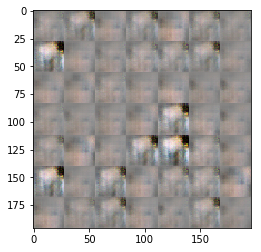

Epoch 0/1 Discriminator loss 0.9188 Generator loss 1.5056
Epoch 0/1 Discriminator loss 0.8800 Generator loss 1.3277
Epoch 0/1 Discriminator loss 0.8973 Generator loss 1.3856
Epoch 0/1 Discriminator loss 0.8445 Generator loss 1.5719
Epoch 0/1 Discriminator loss 0.9500 Generator loss 1.8466
Epoch 0/1 Discriminator loss 1.0952 Generator loss 1.0374
Epoch 0/1 Discriminator loss 0.9048 Generator loss 1.5368
Epoch 0/1 Discriminator loss 1.2533 Generator loss 1.0612
Epoch 0/1 Discriminator loss 1.2236 Generator loss 1.2700
Epoch 0/1 Discriminator loss 0.9799 Generator loss 1.1786


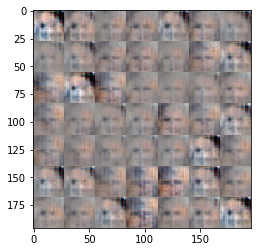

Epoch 0/1 Discriminator loss 1.1015 Generator loss 1.2479
Epoch 0/1 Discriminator loss 0.9926 Generator loss 1.0465
Epoch 0/1 Discriminator loss 1.0195 Generator loss 1.1040
Epoch 0/1 Discriminator loss 1.1604 Generator loss 1.1752
Epoch 0/1 Discriminator loss 1.0707 Generator loss 1.1066
Epoch 0/1 Discriminator loss 0.9447 Generator loss 1.2233
Epoch 0/1 Discriminator loss 1.1058 Generator loss 1.2150
Epoch 0/1 Discriminator loss 1.0378 Generator loss 1.1554
Epoch 0/1 Discriminator loss 1.0351 Generator loss 1.1596
Epoch 0/1 Discriminator loss 2.6704 Generator loss 1.3230


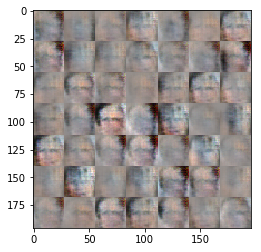

Epoch 0/1 Discriminator loss 1.0378 Generator loss 1.0783
Epoch 0/1 Discriminator loss 1.0864 Generator loss 1.1027
Epoch 0/1 Discriminator loss 1.0701 Generator loss 1.0819
Epoch 0/1 Discriminator loss 1.0142 Generator loss 1.1460
Epoch 0/1 Discriminator loss 1.0632 Generator loss 1.2548
Epoch 0/1 Discriminator loss 1.0389 Generator loss 1.1911
Epoch 0/1 Discriminator loss 1.0338 Generator loss 1.1095
Epoch 0/1 Discriminator loss 1.0895 Generator loss 1.3464
Epoch 0/1 Discriminator loss 1.0239 Generator loss 1.1489
Epoch 0/1 Discriminator loss 1.0991 Generator loss 1.2208


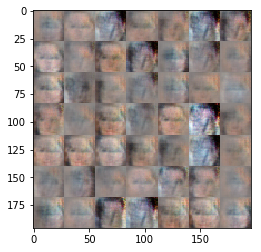

Epoch 0/1 Discriminator loss 1.1897 Generator loss 0.9981
Epoch 0/1 Discriminator loss 0.9708 Generator loss 1.4991
Epoch 0/1 Discriminator loss 1.2797 Generator loss 0.9843
Epoch 0/1 Discriminator loss 1.0524 Generator loss 1.2064
Epoch 0/1 Discriminator loss 1.0135 Generator loss 1.0465
Epoch 0/1 Discriminator loss 1.0140 Generator loss 1.2419
Epoch 0/1 Discriminator loss 8.6044 Generator loss 4.0903
Epoch 0/1 Discriminator loss 1.1445 Generator loss 0.9738
Epoch 0/1 Discriminator loss 1.1059 Generator loss 0.9681
Epoch 0/1 Discriminator loss 1.1130 Generator loss 0.9981


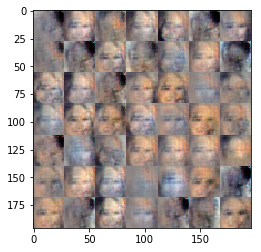

Epoch 0/1 Discriminator loss 1.1885 Generator loss 0.9704
Epoch 0/1 Discriminator loss 1.1126 Generator loss 1.0109
Epoch 0/1 Discriminator loss 1.1213 Generator loss 1.0365
Epoch 0/1 Discriminator loss 1.1261 Generator loss 1.0124
Epoch 0/1 Discriminator loss 1.1034 Generator loss 1.0605
Epoch 0/1 Discriminator loss 1.1958 Generator loss 1.0454
Epoch 0/1 Discriminator loss 1.1578 Generator loss 1.1030
Epoch 0/1 Discriminator loss 1.1862 Generator loss 0.9300
Epoch 0/1 Discriminator loss 1.4198 Generator loss 0.9818
Epoch 0/1 Discriminator loss 1.1920 Generator loss 0.9765


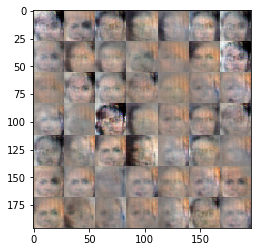

Epoch 0/1 Discriminator loss 1.1273 Generator loss 1.0401
Epoch 0/1 Discriminator loss 1.1889 Generator loss 1.0449
Epoch 0/1 Discriminator loss 1.1172 Generator loss 1.0321
Epoch 0/1 Discriminator loss 1.1044 Generator loss 1.0523
Epoch 0/1 Discriminator loss 1.1628 Generator loss 1.0672
Epoch 0/1 Discriminator loss 1.2685 Generator loss 1.0639
Epoch 0/1 Discriminator loss 1.1213 Generator loss 1.1972
Epoch 0/1 Discriminator loss 1.1304 Generator loss 1.0434
Epoch 0/1 Discriminator loss 1.1657 Generator loss 0.9864
Epoch 0/1 Discriminator loss 1.1798 Generator loss 0.8849


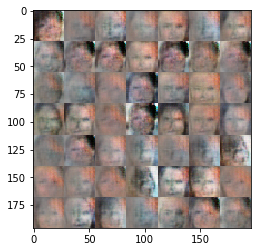

Epoch 0/1 Discriminator loss 1.1773 Generator loss 0.9650
Epoch 0/1 Discriminator loss 1.1820 Generator loss 0.9848
Epoch 0/1 Discriminator loss 1.0872 Generator loss 1.0989
Epoch 0/1 Discriminator loss 1.1762 Generator loss 1.0441
Epoch 0/1 Discriminator loss 1.2390 Generator loss 1.0223
Epoch 0/1 Discriminator loss 1.1478 Generator loss 1.0641
Epoch 0/1 Discriminator loss 1.1847 Generator loss 1.0723
Epoch 0/1 Discriminator loss 1.2107 Generator loss 1.0921
Epoch 0/1 Discriminator loss 1.4640 Generator loss 1.0270
Epoch 0/1 Discriminator loss 1.2661 Generator loss 1.0516


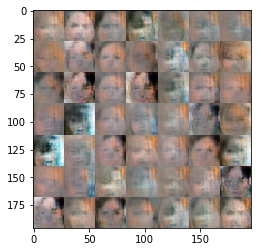

Epoch 0/1 Discriminator loss 1.2764 Generator loss 1.1826
Epoch 0/1 Discriminator loss 1.1956 Generator loss 0.9974
Epoch 0/1 Discriminator loss 1.2081 Generator loss 0.9276
Epoch 0/1 Discriminator loss 1.1670 Generator loss 0.9880
Epoch 0/1 Discriminator loss 1.3128 Generator loss 1.0148
Epoch 0/1 Discriminator loss 1.1366 Generator loss 1.0558
Epoch 0/1 Discriminator loss 1.1874 Generator loss 0.9136
Epoch 0/1 Discriminator loss 1.1800 Generator loss 1.0764
Epoch 0/1 Discriminator loss 1.1389 Generator loss 1.0674
Epoch 0/1 Discriminator loss 1.2559 Generator loss 0.9839


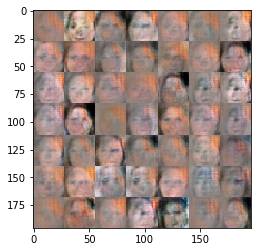

Epoch 0/1 Discriminator loss 1.2234 Generator loss 0.9743
Epoch 0/1 Discriminator loss 1.1664 Generator loss 0.9284
Epoch 0/1 Discriminator loss 1.2090 Generator loss 1.1579
Epoch 0/1 Discriminator loss 1.2251 Generator loss 0.9335
Epoch 0/1 Discriminator loss 1.2615 Generator loss 1.0226
Epoch 0/1 Discriminator loss 1.2678 Generator loss 1.0062
Epoch 0/1 Discriminator loss 1.2298 Generator loss 0.9399
Epoch 0/1 Discriminator loss 1.2495 Generator loss 0.8766
Epoch 0/1 Discriminator loss 1.3136 Generator loss 1.0597
Epoch 0/1 Discriminator loss 1.2084 Generator loss 0.9238


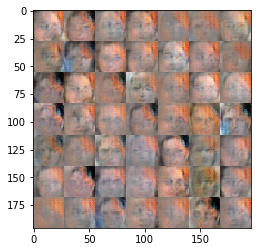

Epoch 0/1 Discriminator loss 1.3268 Generator loss 1.0163
Epoch 0/1 Discriminator loss 1.0845 Generator loss 1.4128
Epoch 0/1 Discriminator loss 1.2315 Generator loss 0.9524
Epoch 0/1 Discriminator loss 1.2565 Generator loss 1.0479
Epoch 0/1 Discriminator loss 1.9091 Generator loss 1.1481
Epoch 0/1 Discriminator loss 1.2503 Generator loss 0.8430
Epoch 0/1 Discriminator loss 1.3326 Generator loss 0.9464
Epoch 0/1 Discriminator loss 1.2294 Generator loss 0.9064
Epoch 0/1 Discriminator loss 1.2316 Generator loss 0.9936
Epoch 0/1 Discriminator loss 1.2721 Generator loss 0.9210


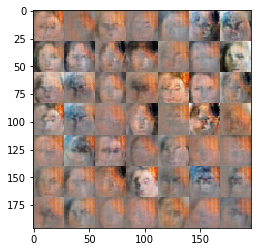

Epoch 0/1 Discriminator loss 1.2642 Generator loss 0.8872
Epoch 0/1 Discriminator loss 1.2671 Generator loss 0.8575
Epoch 0/1 Discriminator loss 1.2305 Generator loss 0.9523
Epoch 0/1 Discriminator loss 1.2095 Generator loss 0.9377
Epoch 0/1 Discriminator loss 1.2453 Generator loss 0.9134
Epoch 0/1 Discriminator loss 1.2105 Generator loss 0.9866
Epoch 0/1 Discriminator loss 1.2581 Generator loss 0.8937
Epoch 0/1 Discriminator loss 1.2006 Generator loss 1.0447
Epoch 0/1 Discriminator loss 1.2166 Generator loss 1.0347
Epoch 0/1 Discriminator loss 1.2479 Generator loss 0.9485


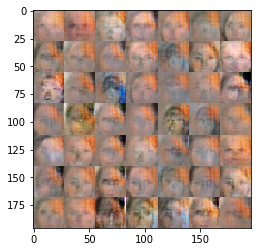

Epoch 0/1 Discriminator loss 1.2315 Generator loss 0.9572
Epoch 0/1 Discriminator loss 1.1910 Generator loss 0.9384
Epoch 0/1 Discriminator loss 1.2949 Generator loss 1.0640
Epoch 0/1 Discriminator loss 1.2070 Generator loss 0.9951
Epoch 0/1 Discriminator loss 2.5514 Generator loss 0.9421
Epoch 0/1 Discriminator loss 1.2021 Generator loss 1.0607
Epoch 0/1 Discriminator loss 1.7269 Generator loss 0.6034
Epoch 0/1 Discriminator loss 1.2808 Generator loss 0.9504
Epoch 0/1 Discriminator loss 1.3360 Generator loss 0.9712
Epoch 0/1 Discriminator loss 1.2812 Generator loss 0.9315


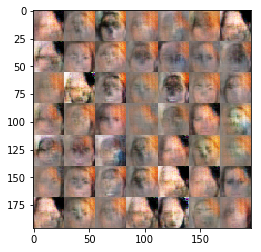

Epoch 0/1 Discriminator loss 1.2565 Generator loss 0.9888
Epoch 0/1 Discriminator loss 1.2574 Generator loss 0.9581
Epoch 0/1 Discriminator loss 1.2705 Generator loss 0.9407
Epoch 0/1 Discriminator loss 1.2456 Generator loss 0.9290
Epoch 0/1 Discriminator loss 1.4057 Generator loss 1.1702
Epoch 0/1 Discriminator loss 1.2239 Generator loss 0.9671
Epoch 0/1 Discriminator loss 1.2569 Generator loss 0.9943
Epoch 0/1 Discriminator loss 1.2909 Generator loss 0.9261
Epoch 0/1 Discriminator loss 1.3013 Generator loss 0.9476
Epoch 0/1 Discriminator loss 1.2545 Generator loss 1.0066


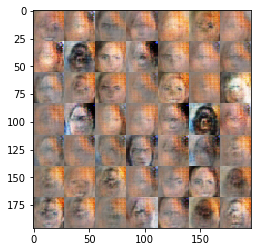

Epoch 0/1 Discriminator loss 1.2396 Generator loss 0.9291
Epoch 0/1 Discriminator loss 1.1831 Generator loss 0.9716
Epoch 0/1 Discriminator loss 1.2667 Generator loss 0.8989
Epoch 0/1 Discriminator loss 1.2553 Generator loss 0.9894
Epoch 0/1 Discriminator loss 1.2985 Generator loss 0.8658
Epoch 0/1 Discriminator loss 1.2600 Generator loss 0.9224
Epoch 0/1 Discriminator loss 1.2624 Generator loss 0.9674
Epoch 0/1 Discriminator loss 1.2340 Generator loss 0.9321


In [47]:
batch_size = 128
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.